In [26]:

from sklearn.datasets import load_svmlight_file
training_set = load_svmlight_file('C:\\Users\\dell\\Desktop\\a9a.t')
validation_set = load_svmlight_file('C:\\Users\\dell\\Desktop\\a9a.t')
#print(training_set)
#print(validation_set)

In [27]:
from io import BytesIO
from sklearn.datasets import load_svmlight_file

#X_training, Y_training = load_svmlight_file(training_set, n_features=123)
#X_validation, Y_validation = load_svmlight_file(validation_set, n_features=123)
X_training = X_training.toarray()
X_validation = X_validation.toarray()

#print(X_training)
#print(X_validation)

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [6]:
import numpy as np
from collections import defaultdict

n_samples_training, n_features_training = X_training.shape
X_training = np.concatenate((X_training, np.ones(shape=(n_samples_training, 1))), axis=1)
Y_training = Y_training.reshape((n_samples_training, 1))

n_samples_validation, n_features_validation = X_validation.shape
X_validation = np.concatenate((X_validation, np.ones(shape=(n_samples_validation, 1))), axis=1)
Y_validation = Y_validation.reshape((n_samples_validation, 1))

#print(Y_training)
#print(Y_validation)

In [7]:
class Model(object):
    def __init__(self, n_features):
        self.params = np.random.random(size=(n_features, 1))
        self.diffs = np.zeros((n_features, 1))
        self.recorder = defaultdict(list)
        
    def train(self, X, Y):
        pass

    def validate(self, X, Y):
        self.__loss__(X, Y, "validation")

    def predict(self, X):
        pass

    def __calculate_gradient__(self, params=None):
        pass

    def __loss__(self, X, Y, key):
        pass


In [8]:
class LogisticRegression(Model):
    def __init__(self, n_features):
        super(LogisticRegression, self).__init__(n_features=n_features)
        self.X_training = None
        self.Y_training = None

    def train(self, X, Y):
        self.X_training = X
        self.Y_training = Y

    def predict(self, X):
        return np.where(np.dot(X, self.params) > 0, 1, 0)

    def __calculate_gradient__(self, params=None):
        if params is None:
            params = self.params
        y_hat = 1 / (1 + np.exp(-np.dot(self.X_training, params)))
        self.diffs = np.dot(self.X_training.transpose(), (y_hat - self.Y_training))

    def __loss__(self, X, Y, key):
        y_hat = 1 / (1 + np.exp(-np.dot(X, self.params)))
        loss = -np.average(Y * np.log(y_hat) + (1 - Y) * np.log(1 - y_hat))
        self.recorder[key].append(loss)

In [9]:
class Optimizer(object):
    def __init__(self, model):
        self.model = model
        self.color = None

    def step(self):
        pass

In [10]:
class SGD(Optimizer):
    def __init__(self, model, learning_rate, momentum=None):
        super(SGD, self).__init__(model=model)
        self.color = "r"
        self.learning_rate = learning_rate
        self.momentum = momentum
        if momentum is not None:
            self.v = np.zeros_like(self.model.diffs)

    def step(self):
        self.model.__calculate_gradient__()
        if self.momentum is None:
            self.model.params -= self.learning_rate * self.model.diffs
        else:
            self.v = self.momentum * self.v + self.learning_rate * self.model.diffs
            self.model.params -= self.v

In [11]:
#Nesterov accelerated gradient (NAG)
#vt=γvt−1+η∇θJ(θ−γvt−1)
#θ=θ−vt
class NAG(Optimizer):
    def __init__(self, model, learning_rate, momentum):
        super(NAG, self).__init__(model=model)
        self.color = "y"
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.v = np.zeros_like(self.model.diffs)
    def step(self):
        self.model.__calculate_gradient__(params=self.model.params - self.momentum * self.v)
        self.v = self.momentum * self.v + self.learning_rate * self.model.diffs
        self.model.params -= self.v
    

In [12]:
class Adam(Optimizer):
    def __init__(self, model, beta, gamma, eta):
        super(Adam, self).__init__(model=model)
        self.color = "g"
        self.beta = beta
        self.gamma = gamma
        self.eta = eta
        self.m = np.zeros_like(self.model.diffs)
        self.G = np.zeros_like(self.model.diffs)
        self.epsilon = 1e-8

    def step(self):
        self.model.__calculate_gradient__()
        self.m = self.beta * self.m + (1 - self.beta) * self.model.diffs
        self.G = self.gamma * self.G + (1 - self.gamma) * self.model.diffs * self.model.diffs
        alpha = self.eta * (np.sqrt(1 - self.gamma)) / (1 - self.beta)
        self.model.params -= alpha * self.m / np.sqrt(self.G + self.epsilon)

In [13]:
class AdaDelta(Optimizer):
    def __init__(self, model, gamma):
        super(AdaDelta, self).__init__(model=model)
        self.color = "b"
        self.gamma = gamma
        self.G = np.zeros_like(self.model.diffs)
        self.delta = np.zeros_like(self.model.diffs)
        self.delta_theta = np.zeros_like(self.model.diffs)
        self.epsilon = 1e-4

    def step(self):
        self.model.__calculate_gradient__()
        self.G = self.gamma * self.G + (1 - self.gamma) * self.model.diffs * self.model.diffs
        self.delta_theta = -(np.sqrt(self.delta + self.epsilon)
                             / np.sqrt(self.G + self.epsilon)) * self.model.diffs
        self.model.params += self.delta_theta
        self.delta = self.gamma * self.delta + (1 - self.gamma) * self.delta_theta * self.delta_theta


In [14]:
class RMSProP(Optimizer):
    def __init__(self, model, leaning_rate, weight_decay):
        self.color = "c"
        super(RMSProP, self).__init__(model=model)
        self.G = np.zeros_like(self.model.diffs)
        self.learning_rate = leaning_rate
        self.weight_decay = weight_decay
        self.epsilon = 1e-8

    def step(self):
        self.model.__calculate_gradient__()
        self.G = self.weight_decay * self.G + (1 - self.weight_decay) * self.model.diffs * self.model.diffs
        self.model.params -= self.learning_rate / np.sqrt(self.G + self.epsilon) * self.model.diffs


In [15]:
Y_training = np.where(Y_training == -1, 0, Y_training)
Y_validation = np.where(Y_validation == -1, 0, Y_validation)
optimizers = [
    SGD(model=LogisticRegression(n_features=123 + 1), learning_rate=0.00001, momentum=0.5),
    NAG(model=LogisticRegression(n_features=123 + 1), learning_rate=0.00001, momentum=0.5),
    Adam(model=LogisticRegression(n_features=123 + 1), beta=0.9, gamma=0.999, eta=0.1),
    AdaDelta(model=LogisticRegression(n_features=123 + 1), gamma=0.95),
    RMSProP(model=LogisticRegression(n_features=123 + 1), leaning_rate=0.1, weight_decay=0.9)
]

In [16]:
max_epoch = 100
batch_size = 10000
for epoch in range(max_epoch):
    indexes = np.random.randint(0, n_samples_training, size=batch_size)
    for optimizer in optimizers:
        optimizer.model.train(X_training[indexes], Y_training[indexes])
        optimizer.step()
        optimizer.model.validate(X_validation, Y_validation)

from sklearn.metrics import classification_report

print("\t\t\t"+optimizers[0].model.__class__.__name__)
print("-"*60)
for optimizer in optimizers:
    print("\t\t\t"+optimizer.__class__.__name__)
    print("-"*60)
    print(classification_report(Y_validation,optimizer.model.predict(X_validation),target_names=["positive", "negative"],digits=3))

			LogisticRegression
------------------------------------------------------------
			SGD
------------------------------------------------------------
             precision    recall  f1-score   support

   positive      0.853     0.926     0.888     12435
   negative      0.669     0.483     0.561      3846

avg / total      0.809     0.821     0.811     16281

			NAG
------------------------------------------------------------
             precision    recall  f1-score   support

   positive      0.848     0.913     0.880     12435
   negative      0.627     0.472     0.539      3846

avg / total      0.796     0.809     0.799     16281

			Adam
------------------------------------------------------------
             precision    recall  f1-score   support

   positive      0.881     0.930     0.905     12435
   negative      0.723     0.594     0.652      3846

avg / total      0.844     0.850     0.845     16281

			AdaDelta
-------------------------------------------------------

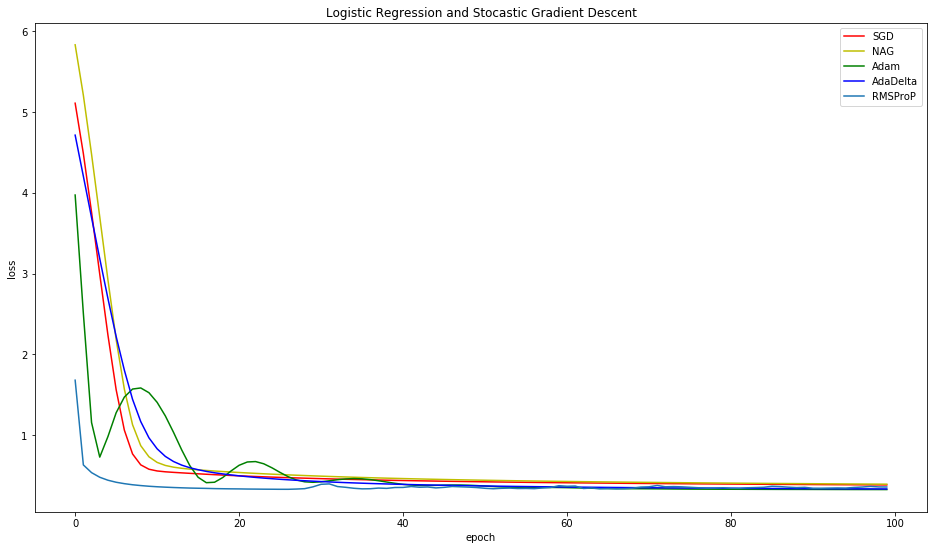

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,9))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Logistic Regression and Stocastic Gradient Descent")
for optimizer in optimizers:
    plt.plot(optimizer.model.recorder["validation"], color=optimizer.color, label=optimizer.__class__.__name__)
plt.legend()
plt.show()